# ICEBERG CLASSIFIER CHALLENGE

**Import the necessary packages**

In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
import cv2
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Making the results reproducible (knowing the random seed of the two libraries)**

In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 97
tf_rand_seed = 82
np.random.seed(np_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  97
tensorflow random seed:  82


# **1. Load and Inspect the data**

In [3]:
data = pd.read_json('../input/train.json')
test_data = pd.read_json('../input/test.json')

In [4]:
data.head(10)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0
5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",b51d18b5,36.9034,1
6,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",31da1a04,34.4751,1
7,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",56929c16,41.1769,0
8,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",525ab75c,35.7829,0
9,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",192f56eb,43.3007,0


In [5]:
test_data.head(10)

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874
5,"[-18.13534927368164, -18.13534927368164, -18.1...","[-14.650325775146484, -14.650325775146484, -14...",a8d9b1fd,35.933020
6,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",29e7727e,42.414200
7,"[-20.162964, -18.16898, -17.023144, -17.023216...","[-30.905346, -28.406647, -25.381365, -28.77645...",92a51ffb,33.638300
8,"[-21.920645, -21.737827, -21.383303, -21.73792...","[-25.53537, -28.514198, -27.75848, -31.280354,...",c769ac97,41.107600
9,"[-14.811565, -16.318594, -17.082613, -16.41037...","[-22.617977, -21.065811, -27.914198, -25.24334...",aee0547d,34.966400


In [6]:
print("Shape of train set:", data.shape)
print("Shape of test set:", test_data.shape)

Shape of train set: (1604, 5)
Shape of test set: (8424, 4)


In [7]:
print("Shape of band 1:",  np.shape(data.band_1.iloc[0]))
print("Shape of band 2:",  np.shape(data.band_2.iloc[0]))

Shape of band 1: (5625,)
Shape of band 2: (5625,)


In [8]:
print("Type of band 1:",  type(data.band_1.iloc[0]))
print("Type of band 2:",  type(data.band_2.iloc[0]))

Type of band 1: <class 'list'>
Type of band 2: <class 'list'>


# **2. Feature Engineering**

## **2.1 Feature engineering on train set**

### 2.1.1 Replacing the na in inc_anlge with mean

In [9]:
data[data['inc_angle']=='na'] = data[data['inc_angle']!='na']['inc_angle'].mean()

### 2.1.2 Converting the angle from degrees to radian

In [10]:
data['inc_angle'] = data['inc_angle'].apply(lambda x: math.radians(x))

In [11]:
data.inc_angle.head()

0    0.766617
1    0.665951
2    0.790388
3    0.764988
4    0.621784
Name: inc_angle, dtype: float64

### 2.1.3 Finding and droping points with missing band1 and band2 data

**Function which return the count and the index of missing data**

In [12]:
def find_missing_data(series, shape):
    
    '''function which return the count and the index of missing data'''    
    count = 0
    missing_list = []
    for i,x in enumerate(series):   
        if np.shape(series.iloc[i]) != shape:
            missing_list.append(i)
            count += 1
            
    return missing_list, count

**Count and list missing points in band1**

In [13]:
missing_list1, count1 = find_missing_data(data.band_1, (5625,))
print("count: ", count1)
print("missing data: ", missing_list1)

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


**Count and list missing points in band2**

In [14]:
missing_list2, count2 = find_missing_data(data.band_2, (5625,))
print("count: ", count1)
print("missing data: ", missing_list2)

count:  133
missing data:  [101, 126, 142, 145, 176, 179, 191, 278, 286, 342, 412, 431, 440, 493, 642, 666, 667, 730, 741, 742, 763, 822, 863, 868, 906, 916, 996, 1041, 1065, 1095, 1199, 1228, 1247, 1257, 1268, 1290, 1345, 1403, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603]


**Check if the missing points are same**

In [15]:
missing_list1 == missing_list2

True

**Function to drop data by index**

In [16]:
def drop_data(df, index):    
    '''function to drop data by index'''
    return df.drop(df.index[index])

**Drop the points with missing band_1 or band_2 images**

In [17]:
data = drop_data(data, missing_list1)

In [18]:
data.shape

(1471, 5)

In [19]:
print("Number of positive classes: ", len(data[data['is_iceberg'] == 1.0]))
print("Number of negative classes: ", len(data[data['is_iceberg'] == 0.0]))

Number of positive classes:  753
Number of negative classes:  718


### 2.1.4 Scale the image data

**3 scaling techniques we can try on**

In [20]:
def standardise_vector(vector):
    '''standardise vector'''
    standardised_vector = (np.array(vector) - np.mean(vector))/np.std(vector)
    return standardised_vector.tolist()

In [21]:
def mean_normalise_vector(vector):
    '''mean normalize vector'''
    normalised_vector = (np.array(vector)-np.mean(vector))/(np.max(vector)-np.min(vector))
    return normalised_vector.tolist()

In [22]:
def min_max_scaler(vector, minimum, maximum, global_min, global_max):
    '''minmaxscaler'''
    X_std  = (np.array(vector)-global_min)/(global_max-global_min)
    scaled_vector = X_std * (maximum - minimum) + minimum
    return scaled_vector.tolist()

**We will use minmaxscaler as the  normalization technique since this works well with images**

To use the minmaxscaler we have to find the global minimum and maximum of band_1 and band_2 data. We create functions to find global minimum and maximum.

In [23]:
def min_finder(data):
    '''
    A function to find the global minimum
    '''
    minimum = 0
    current_minimum = None
    for band in data: 
        current_minimum = np.min(band)
        if current_minimum<minimum:
            minimum = current_minimum
    return minimum

In [24]:
def max_finder(data):
    '''
    A function to find the global maximum
    '''
    maximum = 0
    current_maximum = None
    for band in data: 
        current_maximum = np.max(band)
        if current_maximum>maximum:
            maximum = current_maximum
    return maximum

Find and print global minimum and maximum of band_1 and band_2

In [25]:
band_1_max = max_finder(data['band_1'])
band_2_max = max_finder(data['band_2'])
band_1_min = min_finder(data['band_1'])
band_2_min = min_finder(data['band_2'])
print("band 1 max:",band_1_max)
print("band 2 max:",band_2_max)
print("band 1 min:",band_1_min)
print("band 2 min:",band_2_min)

band 1 max: 34.574917
band 2 max: 20.154249
band 1 min: -45.594448
band 2 min: -45.655499


In [26]:
data['band_1'] = data['band_1'].apply(min_max_scaler, args = (-1,1,band_1_min,band_1_max))
data['band_2'] = data['band_2'].apply(min_max_scaler, args = (-1,1,band_2_min,band_2_max))

In [27]:
data.head(10)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-0.5580334957124831, -0.5399667192075177, -0....","[-0.43773129172292236, -0.5101755745972466, -0...",dfd5f913,0.766617,0.0
1,"[-0.16795965640990163, -0.23476647220543656, -...","[-0.5699975024976542, -0.46296876869973735, -0...",e25388fd,0.665951,0.0
2,"[-0.4763393223833069, -0.4763402703763464, -0....","[-0.3683445498074237, -0.3446907895772523, -0....",58b2aaa0,0.790388,1.0
3,"[-0.42272609992607524, -0.43839822106611426, -...","[-0.46007761646496503, -0.448844417395429, -0....",4cfc3a18,0.764988,0.0
4,"[-0.511347208500404, -0.4404455617179954, -0.4...","[-0.43933582605421917, -0.5320962785026924, -0...",271f93f4,0.621784,0.0
5,"[-0.380684205244734, -0.3806857769174048, -0.5...","[-0.5026039911290954, -0.5154849704028649, -0....",b51d18b5,0.644086,1.0
6,"[-0.5279833637200444, -0.45295098695118763, -0...","[-0.3588255648692046, -0.4323996195821932, -0....",31da1a04,0.601704,1.0
7,"[-0.48595504030747905, -0.5549615741623998, -0...","[-0.4559977345605396, -0.4249081458266639, -0....",56929c16,0.718672,0.0
8,"[-0.2903072888253512, -0.2903055674695689, -0....","[-0.3945610914662673, -0.35623543186945494, -0...",525ab75c,0.624529,0.0
9,"[-0.4617995290345632, -0.4500848796794137, -0....","[-0.48478815022965904, -0.6325111288984119, -0...",192f56eb,0.755740,0.0


### 2.1.5 Reshape the band1 and band2 data into 2D image

In [28]:
band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) 
                   for band in data["band_1"]])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75)
                   for band in data["band_2"]])

In [29]:
print("Shape of band 1 image:",band_1.shape)
print("Shape of band 2 image:",band_2.shape)

Shape of band 1 image: (1471, 75, 75)
Shape of band 2 image: (1471, 75, 75)


## **2.2 Feature engieering on test set**

**We carry out the same feature engineering operations that we carried out on train set**

In [30]:
test_data['inc_angle'] = test_data['inc_angle'].apply(lambda x: math.radians(x))

In [31]:
test_data.inc_angle.head()

0    0.610279
1    0.569240
2    0.654593
3    0.601683
4    0.766529
Name: inc_angle, dtype: float64

In [32]:
missing_list3, count3 = find_missing_data(test_data.band_1, (5625,))
print("count: ", count3)
print("missing data: ", missing_list3)

count:  0
missing data:  []


In [33]:
missing_list4, count4 = find_missing_data(test_data.band_2, (5625,))
print("count: ", count4)
print("missing data: ", missing_list4)

count:  0
missing data:  []


In [34]:
test_data['band_1'] = test_data['band_1'].apply(standardise_vector)
test_data['band_2'] = test_data['band_2'].apply(standardise_vector)

In [35]:
band_1_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) 
                        for band in test_data["band_1"]])
band_2_test = np.array([np.array(band).astype(np.float32).reshape(75, 75) 
                        for band in test_data["band_2"]])

In [36]:
print("Shape of test set band 1 image:",band_1_test.shape)
print("Shape of test set band 2 image:",band_2_test.shape)

Shape of test set band 1 image: (8424, 75, 75)
Shape of test set band 2 image: (8424, 75, 75)


# **3. Train/test/validation split**

**Extract the labels and angles of train set**

In [37]:
labels = data.is_iceberg.values
angles = data.inc_angle.values

**Carry out splits**

In [38]:
# randomly choosing the train and validation indices
train_indices = np.random.choice(len(labels), round(len(labels)*0.75), replace=False)
validation_indices = np.array(list(set(range(len(labels))) - set(train_indices)))

# extract train set
band_1_train = band_1[train_indices]
band_2_train = band_2[train_indices]
angles_train = angles[train_indices]
labels_train = labels[train_indices]

# extract validation set
band_1_validation = band_1[validation_indices]
band_2_validation = band_2[validation_indices]
angles_validation = angles[validation_indices]
labels_validation = labels[validation_indices]

# extract test set
band_1_test = band_1_test
band_2_test = band_2_test
angles_test = test_data.inc_angle.values
test_ids = test_data.id.values

**Covert the types of all data to appropriate numpy dtypes**

In [39]:
band_1_train = band_1_train.astype(np.float32)
band_1_validation = band_1_validation.astype(np.float32)
band_1_test = band_1_test.astype(np.float32)
band_2_train = band_2_train.astype(np.float32)
band_2_validation = band_2_validation.astype(np.float32)
band_2_test = band_2_test.astype(np.float32)
angles_train = angles_train.astype(np.float32)
angles_validation = angles_validation.astype(np.float32)
angles_test = angles_test.astype(np.float32)
labels_train = labels_train.astype(np.float32)
labels_validation = labels_validation.astype(np.float32)
test_ids = test_ids.astype(np.str)

In [40]:
# delete the unnecessary variables out of memory
del(data, test_data, band_1, band_2)

**Examine the shape of the data**

In [41]:
print("Shape of band_1_train:",band_1_train.shape)
print("Shape of band_2_train:",band_1_train.shape)
print("Shape of angles_train:",angles_train.shape)
print("Shape of labels_train:",labels_train.shape)
print("Shape of band_1_validation:",band_1_validation.shape)
print("Shape of band_2_validation:",band_2_validation.shape)
print("Shape of angles_validation:",angles_validation.shape)
print("Shape of labels_validation:",labels_validation.shape)
print("Shape of band_1_test:",band_1_test.shape)
print("Shape of band_2_test:",band_2_test.shape)
print("Shape of angles_test:",angles_test.shape)
print("Shape of iD:",test_ids.shape)

Shape of band_1_train: (1103, 75, 75)
Shape of band_2_train: (1103, 75, 75)
Shape of angles_train: (1103,)
Shape of labels_train: (1103,)
Shape of band_1_validation: (368, 75, 75)
Shape of band_2_validation: (368, 75, 75)
Shape of angles_validation: (368,)
Shape of labels_validation: (368,)
Shape of band_1_test: (8424, 75, 75)
Shape of band_2_test: (8424, 75, 75)
Shape of angles_test: (8424,)
Shape of iD: (8424,)


# **4. Augmenting train set**

## 4.1 Functions to carry out different augmentation techniques

**4.1.1 Image Rotation**

In [42]:
def rotate_image(img, angle = 20):
    
    '''
    A function to rotate image by a given degree
    '''
    
    # rotate image
    original = img.copy()

    M_rotate = cv2.getRotationMatrix2D((37,37),angle,1)
    img_new = cv2.warpAffine(img,M_rotate,(75,75))
    
    length_row = 0
    length_column = 0
    boundary_step = 5
    
    for i in range(len(img_new)):
        if img_new[0,i]!=float(0.0):
            length_row = i
            break
    for i in range(len(img_new)):
        if img_new[i,0]!=float(0.0):
            length_column = i
            break
    
    # subsitute the padding from original image
    img_new[:length_column+boundary_step,:length_row+boundary_step] = \
    original[:length_column+boundary_step,:length_row+boundary_step] 
    img_new[-(length_row+boundary_step):,:length_column+boundary_step] = \
    original[-(length_row+boundary_step):,:length_column+boundary_step]
    img_new[:length_row+boundary_step,-(length_column+boundary_step):] = \
    original[:length_row+boundary_step,-(length_column+boundary_step):]
    img_new[-(length_column+boundary_step):,-(length_row+boundary_step):] = \
    original[-(length_column+boundary_step):,-(length_row+boundary_step):]
    
    return img_new

**4.1.2 Horizontal translation**

In [43]:
def translate_horizontal(image, shift_horizontal = 5):
    
    '''
    A function to translate image horizontally by a shift
    '''
    
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0; 
    if shift_horizontal<0:
        image_slice = img[:,shift_horizontal:].copy()
    if shift_horizontal>0:
        image_slice = img[:,:shift_horizontal].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_horizontal<0:
        img_new[:,shift_horizontal:] = image_slice
    if shift_horizontal>0:
        img_new[:,:shift_horizontal] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.3 Vertical translation**

In [44]:
def translate_vertical(image, shift_vertical = 5):
    
    '''
    A function to translate image vertically by a shift
    '''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_vertical<0:
        img_new[shift_vertical:,:] = image_slice
    if shift_vertical>0:
        img_new[:shift_vertical,:] = image_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.4 Translation along positive diagonal**

In [45]:
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''
    A function to translate image along positive diagonal
    '''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],
                              [0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[shift_diagonal:,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    else:
        img_new[:shift_diagonal,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
    
    return img_new.reshape(75,75).astype(np.float32)

**4.1.5 Translation along negative diagonal**

In [46]:
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''
    A function to translate image along negative diagonal
    '''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],
                              [0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(75,75))
    
    # subsitute the padding from original image
    if shift_diagonal<0:
        img_new[:-shift_diagonal,:] = hor_slice
        img_new[:,shift_diagonal:] = ver_slice
    if shift_diagonal>0:
        img_new[-shift_diagonal:,:] = hor_slice
        img_new[:,:shift_diagonal] = ver_slice
        
    return img_new.reshape(75,75).astype(np.float32)

**4.1.6 Flip Image**

In [47]:
def flip(image, direction = 0):
    
    '''
    A function to flip image
    '''
    img = image.copy()
    return cv2.flip(img,direction)

**4.1.7 Zoom image**

In [48]:
def zoom(image, zoom_shift = 5):
    
    '''
    A function to zoom image
    '''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (75+zoom_shift*2,75+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1
        
        hor_top = img[:zoom_shift,:]
        hor_bottom =img[-zoom_shift:,:]
        ver_left = img[:,:zoom_shift]
        ver_right = img[:,-zoom_shift:]
        
        # scale
        img_new = cv2.resize(img, (75-zoom_shift*2,75-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,
                                     zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0)
        # subsitute the padding from original image
        img_new[:zoom_shift,:] = hor_top
        img_new[-zoom_shift:,:] = hor_bottom
        img_new[:,:zoom_shift] = ver_left
        img_new[:,-zoom_shift:] = ver_right     
        
    return img_new.reshape(75,75).astype(np.float32)

## 4.2 Display sample augmented images

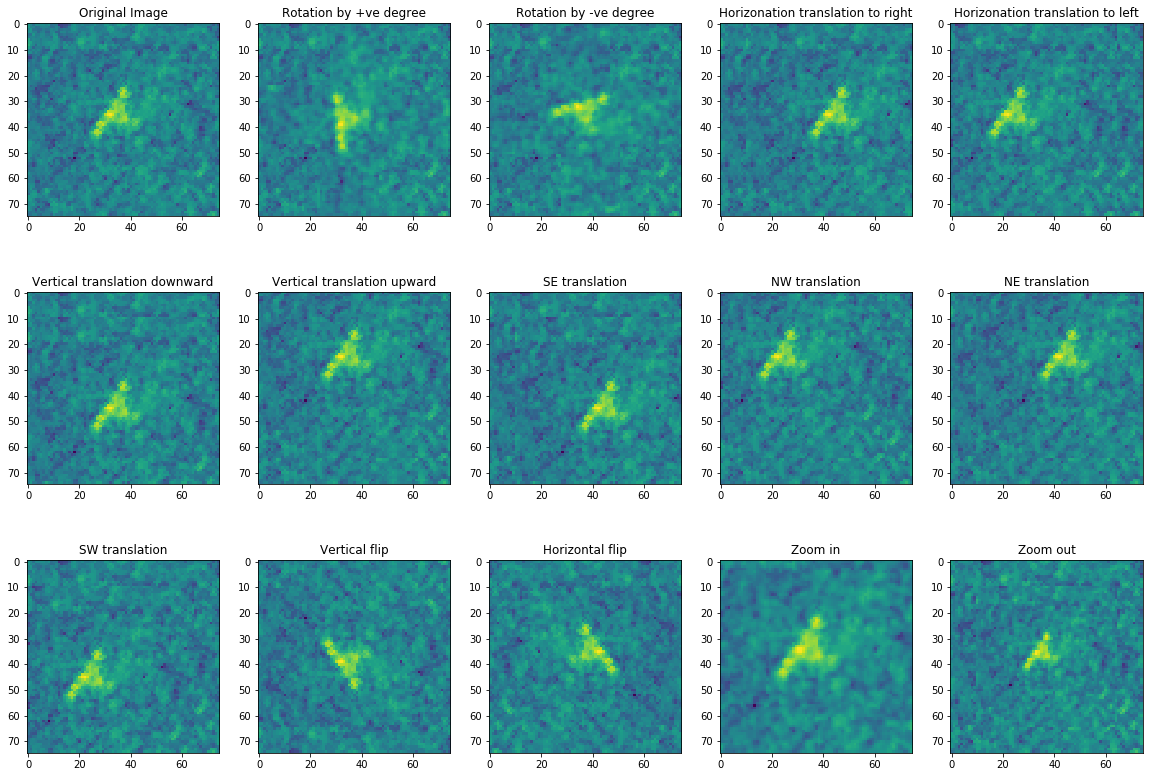

In [49]:
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)
image = band_1_test[3].copy()
plt.subplot(3, 5, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(3, 5, 2)
generated_image = rotate_image(image,40)
plt.title("Rotation by +ve degree")
plt.imshow(generated_image)
plt.subplot(3, 5, 3)
generated_image = rotate_image(image,-40)
plt.title("Rotation by -ve degree")
plt.imshow(generated_image)
plt.subplot(3, 5, 4)
generated_image = translate_horizontal(image,10)
plt.title("Horizonation translation to right")
plt.imshow(generated_image)
plt.subplot(3, 5, 5)
generated_image = translate_horizontal(image,-10)
plt.title("Horizonation translation to left")
plt.imshow(generated_image)
plt.subplot(3, 5, 6)
generated_image = translate_vertical(image,10)
plt.title("Vertical translation downward")
plt.imshow(generated_image)
plt.subplot(3, 5, 7)
generated_image = translate_vertical(image,-10)
plt.title("Vertical translation upward")
plt.imshow(generated_image)
plt.subplot(3, 5, 8)
generated_image = translate_positive_diagonal(image,10)
plt.title("SE translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 9)
generated_image = translate_positive_diagonal(image,-10)
plt.title("NW translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 10)
generated_image = translate_negative_diagonal(image,10)
plt.title("NE translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 11)
generated_image = translate_negative_diagonal(image,-10)
plt.title("SW translation")
plt.imshow(generated_image)
plt.subplot(3, 5, 12)
generated_image = flip(image,0)
plt.title("Vertical flip")
plt.imshow(generated_image)
plt.subplot(3, 5, 13)
generated_image = flip(image,1)
plt.title("Horizontal flip")
plt.imshow(generated_image)
plt.subplot(3, 5, 14)
generated_image = zoom(image,10)
plt.title("Zoom in")
plt.imshow(generated_image)
plt.subplot(3, 5, 15)
generated_image = zoom(image,-10)
plt.title("Zoom out")
plt.imshow(generated_image)
plt.show()

## 4.3 Augmentation of training set

In [50]:
def augment_data(band1, band2, angles, labels):
    
    '''a function to augment band1 and band2 image'''
    
    # list to store the generated data
    band1_generated = []
    band2_generated = []
    angles_generated = []
    labels_generated = []
    
    # iterate through each point in train set
    for i in range(labels.shape[0]):
        
        # rotate by positive degree
        angle = np.random.randint(5,20)
        band1_generated.append(rotate_image(band1[i],angle)) 
        band2_generated.append(rotate_image(band2[i],angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(5,20)
        band1_generated.append(rotate_image(band1[i],-angle)) 
        band2_generated.append(rotate_image(band2[i],-angle))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(3,7)
        band1_generated.append(translate_horizontal(band1[i],+shift)) 
        band2_generated.append(translate_horizontal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(3,7) 
        band1_generated.append(translate_horizontal(band1[i],-shift)) 
        band2_generated.append(translate_horizontal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(3,7)  
        band1_generated.append(translate_vertical(band1[i],+shift)) 
        band2_generated.append(translate_vertical(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(3,7) 
        band1_generated.append(translate_vertical(band1[i],-shift)) 
        band2_generated.append(translate_vertical(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(3,7)  
        band1_generated.append(translate_positive_diagonal(band1[i],+shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(3,7)  
        band1_generated.append(translate_positive_diagonal(band1[i],-shift)) 
        band2_generated.append(translate_positive_diagonal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(3,7)   
        band1_generated.append(translate_negative_diagonal(band1[i],+shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i],+shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(3,7)   
        band1_generated.append(translate_negative_diagonal(band1[i],-shift)) 
        band2_generated.append(translate_negative_diagonal(band2[i],-shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # vertical flip
        band1_generated.append(flip(band1[i],0)) 
        band2_generated.append(flip(band2[i],0))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # horizontal flip
        band1_generated.append(flip(band1[i],1)) 
        band2_generated.append(flip(band2[i],1))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = np.random.randint(2,5)
        band1_generated.append(zoom(band1[i],zoom_shift)) 
        band2_generated.append(zoom(band2[i],zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = np.random.randint(2,5) 
        band1_generated.append(zoom(band1[i],-zoom_shift)) 
        band2_generated.append(zoom(band2[i],-zoom_shift))
        angles_generated.append(angles[i])
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    band1_generated = np.array(band1_generated)
    band2_generated = np.array(band2_generated)
    angles_generated = np.array(angles_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    band1_augmented = np.concatenate((band1, band1_generated),axis=0)
    band2_augmented = np.concatenate((band2, band2_generated),axis=0)
    angles_augmented = np.concatenate((angles, angles_generated),axis=0)
    labels_augmented = np.concatenate((labels, labels_generated),axis=0)
    
    return band1_augmented, band2_augmented, angles_augmented, labels_augmented

In [51]:
# augment train set
band_1_train, band_2_train, angles_train, labels_train = \
    augment_data(band_1_train, band_2_train, angles_train, labels_train)

**One hot encode the labels**

In [52]:
labels_train = pd.get_dummies(labels_train).values
labels_validation = pd.get_dummies(labels_validation).values

**Examine the shape of augmented train set**

In [53]:
print("Shape of band_1_train:",band_1_train.shape)
print("Shape of band_2_train:",band_2_train.shape)
print("Shape of angles_train:",angles_train.shape)
print("Shape of labels_train:",labels_train.shape)

Shape of band_1_train: (16545, 75, 75)
Shape of band_2_train: (16545, 75, 75)
Shape of angles_train: (16545,)
Shape of labels_train: (16545, 2)


# **5. Concatenate the band1 and band2 data into 3D images**

**Here we concatenate band_1 & band_2 images to create 3D images**

In [54]:
image_train = np.concatenate([band_1_train[:, :, :, np.newaxis],
                             band_2_train[:, :, :, np.newaxis]],
                             axis=-1)

In [55]:
image_validation = np.concatenate([band_1_validation[:, :, :, np.newaxis],
                             band_2_validation[:, :, :, np.newaxis]],
                             axis=-1)

In [56]:
image_test = np.concatenate([band_1_test[:, :, :, np.newaxis],
                             band_2_test[:, :, :, np.newaxis]],
                             axis=-1)

In [57]:
# delete the unnecessary variables out of memory
del(band_1_train, band_1_validation, band_1_test, 
    band_2_train, band_2_validation, band_2_test)

**Examine the shape of 3D images of train, validation, and test set**

In [58]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)
print("Shape of image_test:",image_test.shape)

Shape of image_train: (16545, 75, 75, 2)
Shape of image_validation: (368, 75, 75, 2)
Shape of image_test: (8424, 75, 75, 2)


# 6. Create functions to create Inception CNN Network, train the CNN network, and create submission files

**Check the devices available to tensorflow**

In [59]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 630330337167150931
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4911145340338331508
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**If a GPU is available then set our device of choice to the available GPU**

In [60]:
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

## 6.1 A function to create inception module

In [61]:
def create_inception_module(X, num_filters):
    
    '''
    A function which creates inception modules given input and number of filters
    '''

    num_filters_single_conv = num_filters//4

    with tf.device(device):
        one_by_one_1 = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                        kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),
                                        padding="SAME")

    with tf.device(device):
        three_by_three = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                          kernel_size=1, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),
                                          padding="SAME")
        three_by_three = tf.layers.conv2d(three_by_three, filters=num_filters_single_conv, 
                                          kernel_size=3, strides=[1,1],
                                          kernel_initializer=tf.variance_scaling_initializer(),
                                          padding="SAME")

    with tf.device(device):
        five_by_five = tf.layers.conv2d(X, filters=num_filters_single_conv, 
                                        kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),
                                        padding="SAME")
        five_by_five = tf.layers.conv2d(five_by_five, filters=num_filters_single_conv, 
                                        kernel_size=5, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),
                                        padding="SAME")

    with tf.device(device):
        one_by_one_2 = tf.layers.max_pooling2d(X, 3, 1, padding='SAME')
        one_by_one_2 = tf.layers.conv2d(one_by_one_2, filters=num_filters_single_conv, 
                                        kernel_size=1, strides=[1,1],
                                        kernel_initializer=tf.variance_scaling_initializer(),
                                        padding="SAME")

    with tf.device(device):
        conv = tf.concat((one_by_one_1, three_by_three, five_by_five, one_by_one_2), axis=3)

    return conv

## 6.2 A function to create Inception CNN Network by embedding a number of inception modules

In [62]:
def create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
                   conv_filters, max_pool_kernel_size, max_pool_strides, 
                   dense_layers,angle_repeat_vector_size, learning_rate):
    
    '''
    A function to create Inception CNN Network by embedding a number of inception modules
    '''
    # placeholders for image and prediction data
    X = tf.placeholder(tf.float32, shape=[None,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    Y = tf.placeholder(tf.int32, shape=[None, NUM_CLASSES])
    # placeholder for angle
    angle = tf.placeholder(tf.float32, shape=[None])
    # repeat the angle data to make a vector
    angle_repeat_vector = tf.stack([angle]*angle_repeat_vector_size,axis=-1)
    # keep probability for dropout
    keep_prob = tf.placeholder(tf.float32)
     # placeholder for mode of batch normalization
    training = tf.placeholder(tf.bool)
    
    print("####################################### DNN LAYERS #######################################")
    
    # iterate and create inception layers
    for n, conv_filter in enumerate(conv_filters):
        # first inception layer (with batch normalization)
        if n == 0:            
            conv = create_inception_module(X, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size,
                                           max_pool_strides, padding='SAME')
            print(conv)
        # last inception layer (with batch normalization)
        elif n == len(conv_filters)-1:            
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
        # middle inception layers (with batch normalization)
        else:
            conv = create_inception_module(conv, conv_filter)
            print(conv)
            conv = tf.nn.elu(conv)
            print(conv)
            conv = tf.layers.batch_normalization(conv, training=training)
            print(conv)
            conv = tf.layers.max_pooling2d(conv, max_pool_kernel_size, 
                                           max_pool_strides, padding='SAME')
            print(conv)
    
    # flatten layers and concat the repeat vector of angle
    with tf.device(device):
        conv_flatten = tf.layers.Flatten()(conv)
        print(conv_flatten)
        conv_flatten = tf.concat((conv_flatten,angle_repeat_vector), axis=-1)
        print(conv_flatten)
        
    # iterate and create the dense layer
    for n, dense_layer in enumerate(dense_layers):
        # first dense layer (with dropout)
        if n == 0:
            with tf.device(device):
                Y_ = tf.layers.dense(conv_flatten, dense_layer, 
                                     kernel_initializer=tf.variance_scaling_initializer(), 
                                     activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob)
                print(Y_)
        # last dense layer (without dropout)
        elif n == len(dense_layers)-1:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, 
                                     kernel_initializer=tf.variance_scaling_initializer())
                print(Y_)
        # middle dense layers (with droput)
        else:
            with tf.device(device):
                Y_ = tf.layers.dense(Y_, dense_layer, 
                                     kernel_initializer=tf.variance_scaling_initializer(), 
                                     activation=tf.nn.elu)
                print(Y_)
                Y_ = tf.nn.dropout(Y_, keep_prob)
                print(Y_)
                
    print("############################################################################################")
    # softmnax of output
    Y_pred = tf.nn.softmax(Y_)
    # compute predicted class
    Y_pred_cls = tf.argmax(Y_pred, axis=1, output_type=tf.int32)
    # compute true class
    Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
    # compute correct prediction
    correct_prediction = tf.equal(Y_pred_cls, Y_true_cls)
    # compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # cross entropy cost operation
    with tf.device(device):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_,labels=Y)
        cost = tf.reduce_mean(cross_entropy)        
    # update operation
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)    
    with tf.control_dependencies(update_ops):
        with tf.device(device):
            # train step
            train_step = optimizer.minimize(cost)
            
    return X, Y, angle, Y_pred, keep_prob , training, train_step, cost, accuracy

## 6.3 A function to train CNN network

In [63]:
def train_cnn_net(max_iter,batch_size, model_dir, model_name,
                  X, Y, angle,keep_prob, training, train_step,cost, accuracy,
                  image_train, angles_train, labels_train,
                  image_validation,labels_validation,angles_validation):
    
    '''
    A function to train CNN network
    '''
    # start the timer
    start_time = time.time()
    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)
    # lists to store the train loss, validation loss, validation accuracy at each iteration
    train_cost = []
    valid_cost = []
    valid_acc = []
    # variables to store the accuracy, loss, iteration of our best model
    best_accuracy = 0
    best_iteration = None
    # number of training data
    N = len(labels_train)
    # number of complete batches
    num_complete_mini_batches = math.floor(N/batch_size)

    # create a graph session and optimize under it
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # create a progress bar 
        bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
            '[',progressbar.Percentage(),']',
            progressbar.Bar(),
            '(',progressbar.DynamicMessage("train_cost"),')',
            '(',progressbar.DynamicMessage("valid_cost"),')',
            '(',progressbar.DynamicMessage("valid_accuracy"),')',
            '(',progressbar.DynamicMessage("best_accuracy"),')',
            '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
        ])
        # start the progress bar
        bar.start()        
        # counter variable to track the number of iterations
        counter = 0
        
        # iterate until maximum number of iterations is reached
        while True:
            # break out of the inner for loop if maximum number of iterations is reached
            if counter>=max_iter:
                break
            # iterate through the mini batches
            for k in range(0, num_complete_mini_batches+1):
                
                # if the mini batch is a complete batch
                if k < num_complete_mini_batches:
                    batch_indices = np.array(list(range(k * batch_size, k * batch_size + batch_size)))
                # handling the end case when the last mini batch is less than the batch_size
                elif N % batch_size != 0:
                    batch_indices = np.array(list(range(num_complete_mini_batches * batch_size, N)))
                
                # extract images, labels, and angles of the batch
                image_rand_train = image_train[batch_indices]    
                labels_rand_train = labels_train[batch_indices]
                angles_batch = angles_train[batch_indices]
                # feed dict for batch
                feed_dict_batch =  {X: image_rand_train,
                                    angle: angles_batch,
                                    Y: labels_rand_train,
                                    keep_prob: 0.5,
                                    training: True}
                # feed dict for validation
                feed_dict_validation =  {X: image_validation,
                                         angle: angles_validation,
                                         Y: labels_validation,
                                         keep_prob:1.0,
                                         training: False}
                # run optimizer step
                sess.run(train_step, feed_dict=feed_dict_batch)
                
                # compute train cost and append it to the designated list
                temp_train_cost = cost.eval(session=sess, 
                                            feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # compute validation cost and append it to the designated list
                temp_validation_cost = cost.eval(session=sess, 
                                                 feed_dict=feed_dict_validation)
                valid_cost.append(temp_validation_cost)
                # compute validation accuracy and append it to the designated list
                temp_validation_accuracy = accuracy.eval(session=sess, 
                                                         feed_dict=feed_dict_validation)
                valid_acc.append(temp_validation_accuracy)   

                # if validation accuracy is better than best recorded 
                # so far then update the best valid accuracy
                if temp_validation_accuracy > best_accuracy:
                    best_accuracy = temp_validation_accuracy
                    best_iteration = counter+1
                    saver.save(sess, model_dir+model_name, global_step = best_iteration)

                time_diff = (time.time()-start_time)/60

                # print metric info
                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_validation_cost, 
                           valid_accuracy = temp_validation_accuracy, 
                           best_accuracy = best_accuracy, 
                           time_elapsed = time_diff)
                
                # increment counter variable
                counter += 1
                
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break
    
        # finish the progress bar
        bar.finish()
            
    return saver, train_cost, valid_cost, valid_acc, best_accuracy, best_iteration

## 6.4 A function to create submission csv file

In [64]:
def create_submission(saver, test_ids, image_test, angles_test, best_iteration,
                      model_dir, model_name, submission_dir, submission_file,
                      X, Y_pred,angle,keep_prob, training):
    '''
    A function to create submission csv file
    '''    
    with tf.Session() as sess:
        model_path = model_dir+model_name+"-"+str(best_iteration)        
        # restore the model
        saver.restore(sess, model_path)
        # break the test set into k folds 
        n = len(test_ids)
        k = 12
        step = n//k
        # array to store the batch prediction
        preds = np.array([])
    
        # iterate through each fold
        for i in range(k):
            # start and end indices of the fold
            start = (step*i)
            end = (step*(i+1)) 
            # feed dictionary for the fold
            feed_dict_test =  {X: image_test[start:end],
                               angle: angles_test[start:end],
                               keep_prob: 1.0, 
                               training: False}
            # computer predictions of the fold
            fold_preds = Y_pred.eval(session=sess, feed_dict = feed_dict_test)[:,1]
            # append the predictions of the fold to the designated array
            preds = np.append(preds, fold_preds)
            
        # save the submission csv file
        submission = pd.DataFrame({"id":test_ids,"is_iceberg": preds})
        submission.to_csv(submission_dir+submission_file+'.csv', 
                          header = True, index=False)

# 7. Create & train Inception Network and make a submission csv file

**Reset graph**

In [65]:
tf.reset_default_graph()

**Parameters of Inception network**

In [66]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
IMG_CHANNELS = 2
NUM_CLASSES = 2
conv_filters = [128,128,256,512,1024]
dense_layers = [2048,1024,512,256,2]
angle_repeat_vector_size = 1024
max_pool_kernel_size = 2
max_pool_strides = 2
learning_rate=0.000001
max_iter,batch_size = 5000, 256

**Create Inception network**

In [67]:
model_dir = "./model_files/"
model_name = "model"
X, Y, angle, Y_pred, keep_prob , training, train_step, cost, accuracy  = \
create_cnn_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES,
               conv_filters, max_pool_kernel_size, max_pool_strides,
               dense_layers,angle_repeat_vector_size, learning_rate)

####################################### DNN LAYERS #######################################
Tensor("concat:0", shape=(?, 75, 75, 128), dtype=float32, device=/device:GPU:0)
Tensor("Elu:0", shape=(?, 75, 75, 128), dtype=float32)
Tensor("batch_normalization/cond/Merge:0", shape=(?, 75, 75, 128), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 38, 38, 128), dtype=float32)
Tensor("concat_1:0", shape=(?, 38, 38, 128), dtype=float32, device=/device:GPU:0)
Tensor("Elu_1:0", shape=(?, 38, 38, 128), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 38, 38, 128), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 19, 19, 128), dtype=float32)
Tensor("concat_2:0", shape=(?, 19, 19, 256), dtype=float32, device=/device:GPU:0)
Tensor("Elu_2:0", shape=(?, 19, 19, 256), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 19, 19, 256), dtype=float32)
Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 10, 10, 256), dtype=float32)
Tensor("concat_3:0", 

**Train incpetion network**

In [68]:
saver, train_cost, valid_cost, valid_acc, best_accuracy, best_iteration = \
train_cnn_net(max_iter,batch_size, model_dir, model_name,
              X, Y, angle,keep_prob, training, train_step,cost, accuracy,
              image_train, angles_train, labels_train,
              image_validation,labels_validation,angles_validation)

[100%]||(train_cost:  0.094)(valid_cost:  0.287)(valid_accuracy:  0.921)(best_accuracy:  0.927)(time_elapsed:   45.5mins)


**Plot of Cost vs Iter**

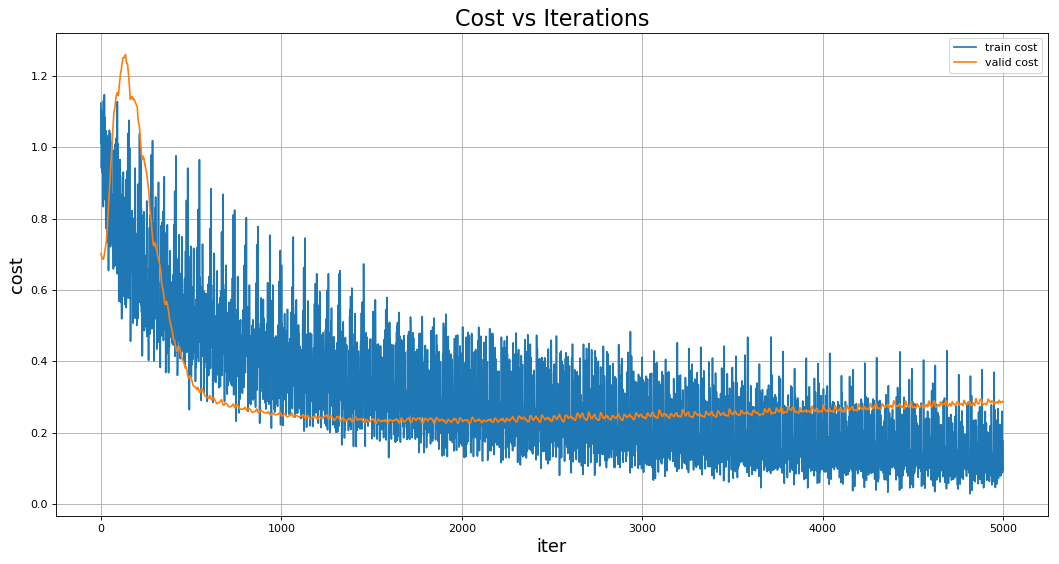

<Figure size 1440x1008 with 0 Axes>

In [69]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train_cost, label = "train cost")
plt.plot(valid_cost, label = "valid cost")
plt.title("Cost vs Iterations", fontsize =20)
plt.xlabel("iter", fontsize=16)
plt.ylabel("cost", fontsize=16)
plt.legend()
plt.grid()
plt.show()
figure_dir = "./model_cost_figures/"
figure_name = "loss_vs_iter"
plt.savefig(figure_dir + figure_name+'.png', bbox_inches='tight')

**Plot of Accuracy vs Iterations**

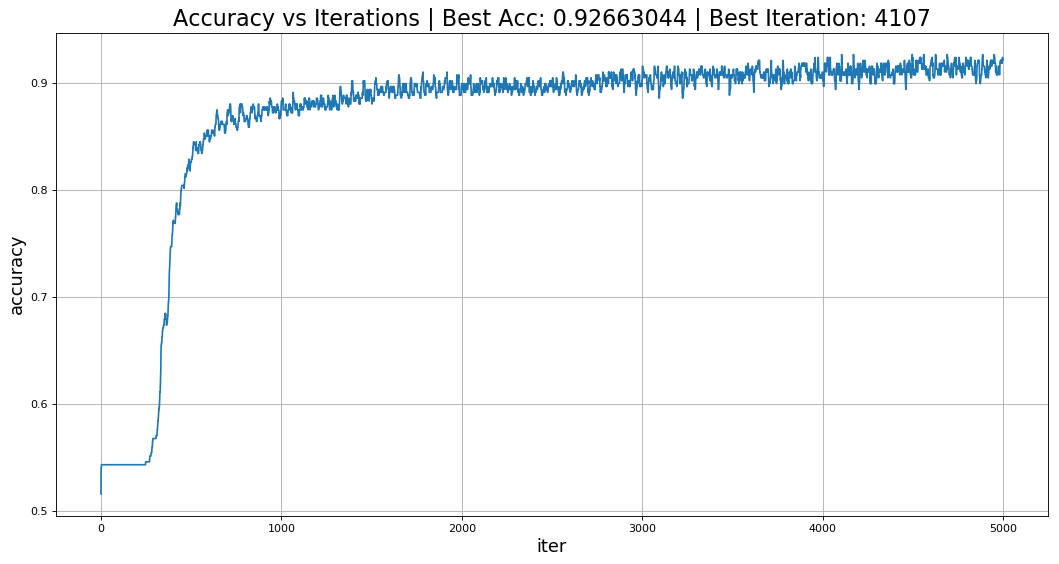

<Figure size 1440x1008 with 0 Axes>

In [70]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(valid_acc,)
plt.title("Accuracy vs Iterations | "+"Best Acc: "+str(best_accuracy)+\
          " | Best Iteration: "+str(best_iteration), fontsize =20)
plt.xlabel("iter", fontsize = 16)
plt.ylabel("accuracy", fontsize = 16)
plt.grid()
plt.show()
figure_dir = "./model_cost_figures/"
figure_name = "acc_vs_iter"
plt.savefig(figure_dir + figure_name+'.png', bbox_inches='tight')

**Create submission files**

In [71]:
# submission_dir = "./submission_files/"
submission_dir = "./submission_files/"
submission_file = "submission"
create_submission(saver, test_ids, image_test, 
                  angles_test, best_iteration,
                  model_dir, model_name, 
                  submission_dir, submission_file,
                  X, Y_pred,angle,keep_prob, training)

INFO:tensorflow:Restoring parameters from ./model_files/model-4107


**Display the submission file**

In [72]:
pd.read_csv(submission_dir+submission_file+".csv").head(50)

,id,is_iceberg
0,5941774d,5.707046e-33
1,4023181e,3.681434e-23
2,b20200e4,5.238396e-26
3,e7f018bb,3.383111e-30
4,4371c8c3,1.151256e-30
5,a8d9b1fd,5.924679e-20
6,29e7727e,0.000000e+00
7,92a51ffb,2.915658e-29
8,c769ac97,1.262673e-37
9,aee0547d,0.000000e+00
